In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Model Description

The implied volatility surface plays a crucial role in derivative pricing and risk management. Constructing this surface from listed option prices usually involves two main steps. First, since forward prices are not directly available in the market, a forward curve must be derived in a way that aligns with the observed option prices. Second, once the forward curve is determined, an implied volatility skew must be calibrated to match the observed prices of the options.

### Implied Forward

European option prices imply a forward price and a corresponding dividend through call-put parity. One practical approach is to fit cubic spline curves to the listed out-of-the-money call and put prices and determine the at-the-money strike where the two curves intersect.

### Implied Dividend

European companies typically pay cash dividends on a quarterly, semi-annual, or annual basis, with a noticeable seasonality in their dividend patterns. As a result, practitioners often forecast future dividend payment dates by assuming the same payment days and months as in previous years. A new "seasoned" dividend curve is then bootstrapped as follows:

Under the Non-Arbitrage assumption:  

$$
F_{T^{Exp}_n} = S_t × e^{r (T^{Exp}_n-t)} - ∑_{k ∈ [1,n]}d_k × e^{r(T^{Exp}_n-T_k)}
$$  

Therefore:  

$$
d_n = e^{-r\left(T^{Exp}_n-T_n\right)} × \left( S_t × e^{r \left(T^{Exp}_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T^{Exp}_n-T_k\right)} - F_{T^{Exp}_n} \right)
$$  

And finally:  

$$
d_n = S_t × e^{r \left(T_n-t\right)} - ∑_{k ∈ [1,n-1]}d_k × e^{r\left(T_n-T_k\right)} - F_T × e^{-r(T-T_n)}
$$  

Where:  

- $S_t$ is the spot price at $t$
- $r$ is the zero-coupon rate
- $\left(F_{T^{Exp}_n}\right)_n$ are the implied forwards at the market option expiries $\left(T^{Exp}_n\right)_n$
- $(d_k)_k$ are the projected cash dividends paid at the projected ex-dividend dates $(T_k)_k$

On the other hand, practitioners typically assume continuous dividend yield curves for the indices. The most straightforward method to construct these curves is by assuming a piecewise constant curve between the market option expiries:

Under the Non-Arbitrage assumption:  

$$
F_{T^{Exp}_n} = S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)}
$$  

Therefore:  

$$
q_n = \frac{\ln\left( S_t × e^{r \left(T^{Exp}_n-t\right) - ∑_{k ∈ [1,n-1]}q_k × \left(T^{Exp}_{k} - T^{Exp}_{k-1} \right)} / F_{T^{Exp}_n}\right)}{\left( T^{Exp}_n - T^{Exp}_{n-1}\right)}
$$  

Where:  
$(q_k)_k$ are the piecewise constant instantaneous forward dividend yields between $\left( T^{Exp}_k - T^{Exp}_{k-1}\right)$  

Cash and yield dividends can then be flat extrapolated after the last market option expiry.

### Implied Volatility

Given the implied forwards at the listed maturities, volatilities can be numerically computed for each listed strike using the Black-Scholes model. In this project, we apply the Newton-Raphson algorithm. The entire volatility surface is then constructed by using interpolation and extrapolation methods across the strike and expiry axes.

## Application: CAC40 Listed Index Options

Now, let's derive the forward and dividend curves, along with the volatility surface, for the CAC40 implied volatility surface. To achieve this, we use the CAC40 European market option quotes retrieved as of February 12, 2025, from the EURONEXT website:


Analysis Date :  2025-02-12
-----------------------------------------------
CAC40 Close Price :  8042.19
-----------------------------------------------
CAC40 Market Options :
            Expiry   Strike    Call      Put
0    February-2025   7925.0  151.83    27.92
1    February-2025   7950.0  132.52    33.59
2    February-2025   7975.0  114.13    40.18
3    February-2025   8000.0   96.79    47.82
4    February-2025   8025.0   81.15    57.17
..             ...      ...     ...      ...
137  December-2029   8000.0  977.10  1115.35
138  December-2029   8400.0  808.07  1308.91
139  December-2029   8800.0  665.26  1528.71
140  December-2029   9600.0  450.36  2039.01
141  December-2029  10400.0  312.97  2626.83

[142 rows x 4 columns]
-----------------------------------------------
EURIBOR6M Zero-Coupon Rate Curve :
    Expiry  ZCRate
0     0.02  0.0268
1     0.25  0.0264
2     0.50  0.0251
3     0.75  0.0239
4     1.00  0.0233
5     1.25  0.0228
6     1.50  0.0226
7     1.75  0.0225
8     

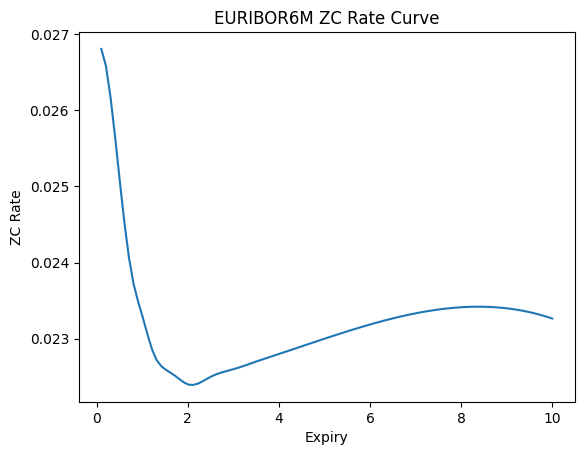

In [ ]:
import datetime
import pandas as pd
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

as_of_date = datetime.date(2025, 2, 12)
print("Analysis Date : ", as_of_date)
print("-----------------------------------------------")

eq_underlying = "CAC40"
S0 = 8042.19
print(eq_underlying + " Close Price : ", S0)
print("-----------------------------------------------")

# Define base path to your datasets folder in Drive
drive_base_path = "/content/drive/MyDrive/"

# Define filenames using variables
option_data_path = drive_base_path + eq_underlying + "_MarketOptions_" + as_of_date.strftime('%d%m%Y') + ".csv"

# Load and display option data
option_data = pd.read_csv(option_data_path)
print(eq_underlying + " Market Options :")
print(option_data)
print("-----------------------------------------------")

# Load and display rate data
rate_underlying = "EURIBOR6M"
rate_data_path = drive_base_path + rate_underlying + "_ZCRates_" + as_of_date.strftime('%d%m%Y') + ".csv"
print(rate_underlying + " Zero-Coupon Rate Curve :")
rates_data = pd.read_csv(rate_data_path)
print(rates_data)

plt.title(rate_underlying + " ZC Rate Curve")
plt.ylabel("ZC Rate")
plt.xlabel("Expiry")
x_axis = np.linspace(0.1, 10, 99)
zc_rate = interp1d(rates_data['Expiry'], rates_data['ZCRate'], kind='cubic', fill_value="extrapolate")
plt.plot(x_axis, zc_rate(x_axis))
plt.show()

First, let's convert the expiry dates. According to EURONEXT documentation, these dates correspond to the third Friday of each month :

In [ ]:
def third_friday(month, year):
    """
    Returns the third friday of month/year.
    """
    result = datetime.date(year, month, 15)
    nb = result.weekday()
    if nb != 4:
        # Replace just the day (of month)
        result = result.replace(day=(15 + (4 - nb) % 7))
    return result

# Computes the exact option expiry (Third friday of months) :
months_nb = {"January" : 1, "February" : 2, "March" : 3, "April" : 4, "May" : 5, "June" : 6, "July" : 7,
               "August" : 8 , "September" : 9, "October" : 10, "November" : 11, "December" : 12}
for i, row in option_data.iterrows():
    month, year = row['Expiry'].split("-")
    month, year = months_nb[month], int(year)
    option_data.at[i,'Expiry'] = (third_friday(month, year) - as_of_date).days / 365

print(eq_underlying + " Market Options :")
option_data

CAC40 Market Options :


,Expiry,Strike,Call,Put
0,0.024658,7925.0,151.83,27.92
1,0.024658,7950.0,132.52,33.59
2,0.024658,7975.0,114.13,40.18
3,0.024658,8000.0,96.79,47.82
4,0.024658,8025.0,81.15,57.17
...,...,...,...,...
137,4.857534,8000.0,977.10,1115.35
138,4.857534,8400.0,808.07,1308.91
139,4.857534,8800.0,665.26,1528.71
140,4.857534,9600.0,450.36,2039.01


Next, let's gather the data and store it in global dictionaries :

In [ ]:
def collect_data(option_data):
    """
    Collects data and store it in dictionaries.
    """
    strikes, call_prices, put_prices = dict(), dict(), dict()
    expiries = np.sort(np.unique(option_data['Expiry']))
    for exp in expiries :
        df = option_data[option_data['Expiry'] == exp]
        df = df.sort_values(by=['Strike'])
        strikes[exp], call_prices[exp], put_prices[exp] = list(df['Strike']), list(df['Call']), list(df['Put'])
    return {"Strikes" : strikes, "Call Prices" : call_prices, "Put Prices" : put_prices}

# Collected Data
data = collect_data(option_data)
strikes = data["Strikes"]
market_expiries = list(strikes.keys())
call_prices = data["Call Prices"]
put_prices = data["Put Prices"]

Now, let's implement a proof of concept for deriving the forward using the method explained earlier. We will select the very last listed expiry and demonstrate the intersection of the fitted curves on the out-of-the-money call and put listed options, which corresponds to the at-the-money strike, and thus the implied forward :

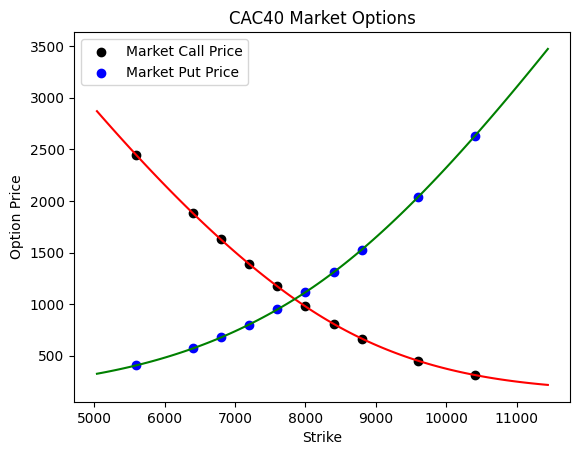

In [ ]:
expiry = market_expiries[-1]

plt.title(eq_underlying + " Market Options")
plt.ylabel("Option Price")
plt.xlabel("Strike")
plt.scatter(strikes[expiry], call_prices[expiry], label="Market Call Price", color="black")
plt.scatter(strikes[expiry], put_prices[expiry], label="Market Put Price", color="blue")
x_axis = np.linspace(list(strikes[expiry])[0] * 0.9, list(strikes[expiry])[-1] * 1.1, 99)
call_price_func = interp1d(strikes[expiry], call_prices[expiry], kind='cubic', fill_value="extrapolate")
plt.plot(x_axis, call_price_func(x_axis), color="red")
put_price_func = interp1d(strikes[expiry], put_prices[expiry], kind='cubic', fill_value="extrapolate")
plt.plot(x_axis, put_price_func(x_axis), color="green")
plt.legend(loc="upper left")
plt.show()

In [ ]:
import sys

def implied_forward(strikes, call_prices, put_prices, n_max=1000, eps=1e-6):
    """
    Implied forward using the Call / Put parity.
    Bisection algorithm is applied to a decreasing function : K => Call(K) - Put(K).
    """
    # Cubic Spline Interpolation / Extrapolation of Market Prices
    call_price_func = interp1d(strikes, call_prices, kind='cubic', fill_value="extrapolate")
    put_price_func = interp1d(strikes, put_prices, kind='cubic', fill_value="extrapolate")

    # ATM Strike (Forward) Solver
    n = 1
    x_min = strikes[0]
    x_max = strikes[-1]
    while n <= n_max:
        strike = (x_min + x_max) / 2
        obj_func = call_price_func(strike) - put_price_func(strike)
        if (obj_func == 0) or (x_max - x_min <= eps):
            return strike
        if obj_func < 0:
            x_max = strike
        else:
            x_min = strike
        n += 1
    return sys.exit("The algorithm failed to converge !")

# Store the Implied Forwards in a dictionary
implied_forwards = dict()
for exp in market_expiries:
    implied_forwards[exp] = round(implied_forward(strikes[exp], call_prices[exp], put_prices[exp]), 4)

print(eq_underlying + " Implied Forwards :")
for exp in market_expiries :
    print("Implied forward at " + str(round(exp, 4)) + ":", round(implied_forwards[exp], 4))

CAC40 Implied Forwards :
Implied forward at 0.0247: 8048.999
Implied forward at 0.1014: 8066.5026
Implied forward at 0.1781: 8079.0099
Implied forward at 0.3507: 7943.4966
Implied forward at 0.6: 7987.5061
Implied forward at 0.8493: 8003.0031
Implied forward at 1.0986: 8039.0019
Implied forward at 1.3479: 7931.0011
Implied forward at 1.5973: 7944.0033
Implied forward at 1.8466: 7969.9976
Implied forward at 2.8438: 7897.9978
Implied forward at 3.8411: 7872.9996
Implied forward at 4.8575: 7847.4929


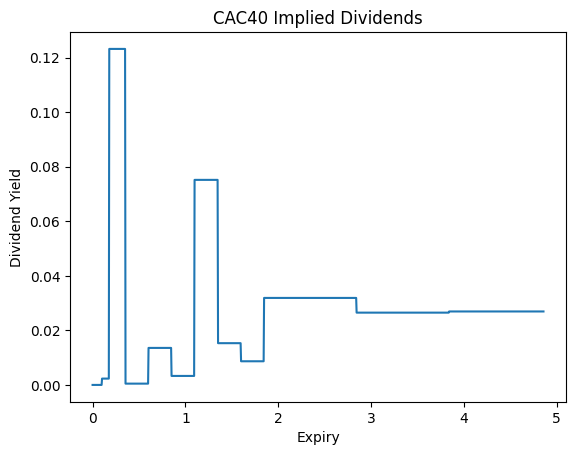

In [ ]:
def implied_divs(implied_forwards):
    """
    Implied Dividend Yields : Piecewise constant instantaneous forwards.
    """
    dividends = dict()
    cumul_div = 0.
    exp_prev = 0
    for exp in market_expiries:
        dividends[exp] = max(np.log(S0 * np.exp(zc_rate(exp) * exp - cumul_div) / implied_forwards[exp]) / (exp - exp_prev), 0)
        cumul_div += dividends[exp] * (exp - exp_prev)
        exp_prev = exp
    return  dividends

divs = implied_divs(implied_forwards)

# Dividend function : Piece-Wise Interpolation / Extrapolation
div_func = interp1d([0] + market_expiries, list(divs.values()) + [list(divs.values())[-1]],
                    kind='previous', fill_value="extrapolate")

plt.title(eq_underlying + " Implied Dividends")
plt.ylabel("Dividend Yield")
plt.xlabel("Expiry")
x_axis = np.linspace(0, market_expiries[-1], 1000)
plt.plot(x_axis, div_func(x_axis))
plt.show()

Significant dividend yields are implied around Junes, as most CAC40 companies tend to detach and pay dividends between April and July. Now, let's take a closer look at the CAC40 implied forward curve:

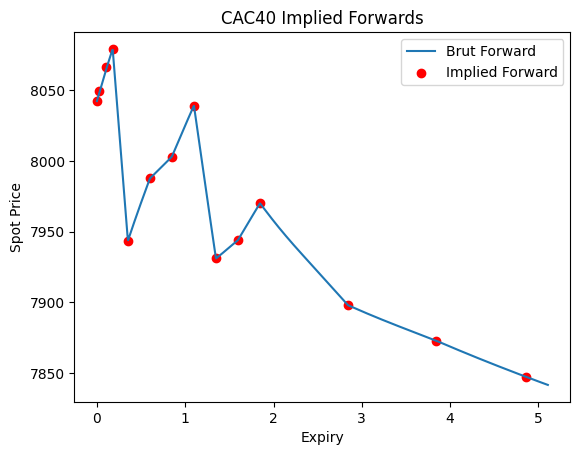

In [ ]:
from scipy.signal import savgol_filter

def calc_forward(exp, div_func):
    """
    Computes the forward up to exp, given the dividend yield function.
    """
    expiries = [0] + market_expiries + [exp]
    expiries = sorted(list(set(expiries)))
    expiries = expiries[:expiries.index(exp) + 1]
    cumul_div = 0
    for i in range(len(expiries) - 1):
        cumul_div += (expiries[i + 1] - expiries[i]) * div_func(expiries[i])
    return S0 * np.exp(zc_rate(exp) * exp - cumul_div)

def forward_curve(div_func, apply_smoothness=False, dt= 1e-4, n_interv=41, order=3):
    """
    Computes the forward curve function, using calc_forward.
    A smoothness is applied if apply_smoothness is True.
    """
    if not apply_smoothness :
        return (lambda exps : [calc_forward(exp, div_func) for exp in exps])
    grid_t = list(np.linspace(0, market_expiries[-1], int(1/dt))) +  market_expiries
    grid_t = sorted(list(set(grid_t)))
    calc_fwd_func = lambda exps : [calc_forward(exp, div_func) for exp in exps]
    smooth_fwds = savgol_filter(calc_fwd_func(grid_t), n_interv, order)
    return interp1d(grid_t, smooth_fwds, kind='linear', fill_value="extrapolate")

# Forward Implied Curve
plt.title(eq_underlying + " Implied Forwards")
plt.ylabel("Spot Price")
plt.xlabel("Expiry")
x_axis = np.linspace(0, market_expiries[-1] + 0.25, 1000)
brut_fwd_curve = forward_curve(div_func)
plt.plot(x_axis, brut_fwd_curve(x_axis), label="Brut Forward")
plt.scatter([0] + market_expiries, [S0] + list(implied_forwards.values()), color="red", label="Implied Forward")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from scipy.stats import norm
from scipy import optimize

def collect_otm_options(implied_forwards):
    """
    Filters the listed options and collect the OTM ones.
    """
    otm_options = dict()
    for exp in market_expiries:
        strikes_exp = strikes[exp]
        calls_exp = call_prices[exp]
        puts_exp = put_prices[exp]
        forward_exp = implied_forwards[exp]
        otm_options_exp = []
        for i in range(len(strikes_exp)):
            otm_options_exp.append(puts_exp[i] if strikes_exp[i] <= forward_exp else calls_exp[i])
        otm_options[exp] = otm_options_exp
    return otm_options

def bs_price(isCall, expiry, forward, strike, vol) :
    """
    The Black-Scholes price.
    """
    v2T = vol**2 * expiry
    d1 = (np.log(forward / strike) + v2T / 2) / v2T**0.5
    d2 = d1 - v2T**0.5
    r = zc_rate(expiry)
    phi = 1 if isCall == True else  -1
    return np.exp(-r * expiry) * phi * (forward * norm.cdf(phi * d1) - strike * norm.cdf(phi * d2))

def bs_vega(expiry, forward, strike, vol) :
    """
    The Black-Scholes Vega greek.
    The derivative of the option value with respect to the volatility of the underlying asset.
    """
    v2T = vol**2 * expiry
    d2 = (np.log(forward / strike) - v2T / 2) / v2T**0.5
    r = zc_rate(expiry)
    return np.exp(-r * expiry) * strike * norm.pdf(d2) * expiry**0.5

def nr_implied_vol(isCall, expiry, forward, strike, target_price):
    """
    Volatility Solver : The Newton-Raphson algorithm
    """
    f = lambda vol : bs_price(isCall, expiry, forward, strike, vol) - target_price
    f_deriv = lambda vol : bs_vega(expiry, forward, strike, vol)
    try:
        return optimize.newton(f, 0.5, f_deriv, maxiter=250, tol=1e-06)
    except:
        print("\n /!\ Warning : The NR algorithm failed to imply a volatility for Strike " + str(strike) + " at expiry " + \
              str(round(expiry, 4)) + "\n")
        return 0

def implied_vol_surface(implied_forwards, otm_options):
    """
    Returns a dictionary of Black implied volatilities, using nr_implied_vol.
    """
    implied_vols = dict()
    for exp in market_expiries:
        strikes_exp = strikes[exp]
        forward_exp = implied_forwards[exp]
        implied_vols_exp = []
        cleaned_strikes = []
        for i in range(len(strikes_exp)):
            isCall = (strikes_exp[i] > forward_exp)
            implied_vol = nr_implied_vol(isCall, exp, implied_forwards[exp], strikes_exp[i], otm_options[exp][i])
            if implied_vol != 0:
                implied_vols_exp.append(implied_vol)
                cleaned_strikes.append(strikes_exp[i])
        implied_vols[exp] = implied_vols_exp
        strikes[exp] = cleaned_strikes
    return implied_vols

def implied_vol(implied_vol_surface, T, K, interp_meth='linear'):
    """
    Interpolate / Extrapolate the Black implied vol.
    Expiry : Linear V2T interpolation - Flat Vol extrapolation.
    Strike : interp_meth (Linear by default) interpolatione and extrpolation.
    """
    if (T <= market_expiries[0]) or (T >= market_expiries[-1]) or (T in market_expiries):
        exp = market_expiries[0] if (T <= market_expiries[0]) else \
             (market_expiries[-1] if (T >= market_expiries[-1]) else T)
        return interp1d(strikes[exp], implied_vol_surface[exp], kind=interp_meth, fill_value="extrapolate")(K)
    else:
        expiries = market_expiries + [T]
        expiries.sort()
        index = expiries.index(T)
        # Prev
        T_prev = expiries[index - 1]
        strikes_prev = strikes[T_prev]
        skew_prev = implied_vol_surface[T_prev]
        vol_prev = interp1d(strikes_prev, skew_prev, kind=interp_meth, fill_value="extrapolate")(K)
        # Next
        T_next = expiries[index + 1]
        strikes_next = strikes[T_next]
        skew_next = implied_vol_surface[T_next]
        vol_next = interp1d(strikes_next, skew_next, kind=interp_meth, fill_value="extrapolate")(K)
        # Linear V2T
        return  np.sqrt(interp1d([T_prev, T_next], [vol_prev**2 * T_prev, vol_next**2 * T_next], kind=interp_meth)(T) / T)

# Black Implied Volatilities
otm_options = collect_otm_options(implied_forwards)
implied_vols = implied_vol_surface(implied_forwards, otm_options)
print(eq_underlying + " Implied Volatilities :")
for exp in market_expiries :
    print("Implied volatilities at " + str(round(exp, 4)) + ":", [round(vol, 4)  for vol in implied_vols[exp]])

CAC40 Implied Volatilities :
Implied volatilities at 0.0247: [np.float64(0.1479), np.float64(0.1449), np.float64(0.1418), np.float64(0.1385), np.float64(0.1361), np.float64(0.1337), np.float64(0.1317), np.float64(0.1301), np.float64(0.1289), np.float64(0.1275), np.float64(0.1258)]
Implied volatilities at 0.1014: [np.float64(0.1584), np.float64(0.1541), np.float64(0.1501), np.float64(0.146), np.float64(0.1427), np.float64(0.1395), np.float64(0.1367), np.float64(0.1343), np.float64(0.1323), np.float64(0.1304), np.float64(0.1288)]
Implied volatilities at 0.1781: [np.float64(0.1567), np.float64(0.1532), np.float64(0.1499), np.float64(0.1471), np.float64(0.1438), np.float64(0.1411), np.float64(0.1386), np.float64(0.1363), np.float64(0.1341), np.float64(0.1303), np.float64(0.1273)]
Implied volatilities at 0.3507: [np.float64(0.15), np.float64(0.1476), np.float64(0.1452), np.float64(0.143), np.float64(0.1408), np.float64(0.1386), np.float64(0.1368), np.float64(0.1352), np.float64(0.1336), np.

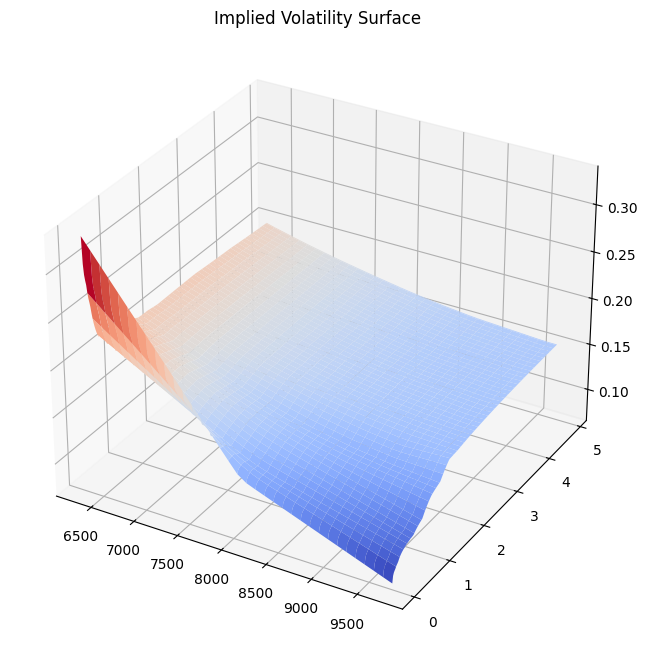

In [ ]:
from matplotlib import cm
plt.rcParams["figure.figsize"] = (11,8)

K_min = 0.8 * max([min(strikes[exp]) for exp in market_expiries])
K_max = 1.2 * min([max(strikes[exp]) for exp in market_expiries])
K = np.arange(K_min, K_max, 100)
T = np.arange(market_expiries[0], market_expiries[-1], 0.02)
K, T = np.meshgrid(K, T)

def vol(K, T, total_var=False):
    vols = np.zeros(shape=K.shape)
    for t in range(vols.shape[0]):
        for k in range(vols.shape[1]):
            vol = implied_vol(implied_vols, T[t][k], K[t][k])
            vols[t, k] =  vol**2 * T[t][k] if total_var else vol
    return vols

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(K, T, vol(K, T), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Implied Volatility Surface")
plt.show()

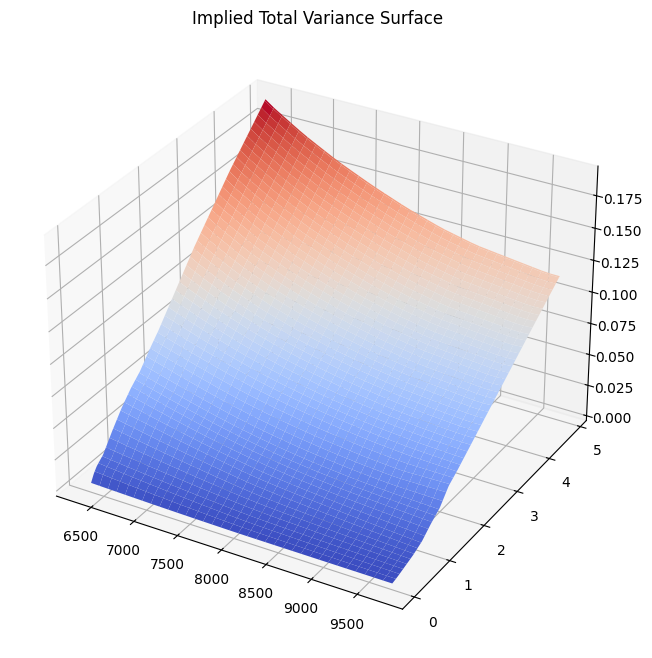

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(K, T, vol(K, T, True), cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.title("Implied Total Variance Surface")
plt.show()